In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
#!which python

In [462]:
import arviz as az
from model import model_sim, param_gen
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import json
import os

az.style.use("default")

In [199]:
subj_data_all = pd.read_csv("./Data/e1_data.csv")
group_id = 0
round_id = 0
subj_data = subj_data_all[(subj_data_all['group'] == group_id) & (subj_data_all['round'] == round_id)]
fitting_data = np.load(f"data/e1_fitting_data/SG_pars_poisson_{group_id}.npy", allow_pickle=True)
fitting_data_as = np.load(f"data/e1_fitting_data/AS_pars_poisson_{group_id}.npy", allow_pickle=True)

In [200]:
agent_id = 0
pars = ["agent_id", "group_id", "lambda","beta","tau"] # ,"eps_soc"

fitted_params = pd.DataFrame(data=np.exp(fitting_data_as[agent_id * 8 + round_id, 0, 2:]),
                             index=pars[2:], columns=["value"])

for l, p in zip(pars[2:], np.exp(fitting_data[agent_id * 8 + round_id, 0, 2:])):
    print(f"{l}: {p}")

lambda: 0.7265764656663888
beta: 0.44939030271475666
tau: 0.01856678856848348


In [201]:
agent_id = 0
pars = ["agent_id", "group_id", "lambda","beta","tau","eps_soc"]

fitted_params = pd.DataFrame(data=np.exp(fitting_data[agent_id * 8 + round_id, 0, 2:]), index=pars[2:], columns=["value"])

for l, p in zip(pars[2:], np.exp(fitting_data[agent_id * 8 + round_id, 0, 2:])):
    print(f"{l}: {p}")

lambda: 0.7265764656663888
beta: 0.44939030271475666
tau: 0.01856678856848348
eps_soc: 18.999999999999996


In [202]:
fitted_params.loc['lambda', 'value']

0.7265764656663888

In [203]:
env_id = subj_data.env.unique()[0]

In [474]:
path = 'data/environments'
json_files = [file for file in os.listdir(path) if file.endswith('_canon.json')]
envList_all = []
for file in json_files:
    f=open(os.path.join(path, file))
    envList_all.append(json.load(f))

# select only one environment
envList =  [[envList_all[i][env_id]] for i in range(len(envList_all))]

torch.manual_seed(1)

np.random.seed(42)
n_groups_simulation = 2000
pars = param_gen(4, n_groups_simulation, hom=True, models=3)

pars[0][0]

{'lambda': 0.6055349943666803,
 'beta': 0.42017806748106945,
 'tau': 0.00728070961204776,
 'gamma': 0.0,
 'alpha': 0.0,
 'eps_soc': 0.7255074589209543,
 'dummy': 0.0}

### Training NLE

In [475]:
from sbi.inference import NLE
from sbi.utils import BoxUniform, MultipleIndependent, mcmc_transform
from torch.distributions import LogNormal, Exponential

In [476]:
params = ["lambda", "beta", "tau", "eps_soc"]  #
prior = MultipleIndependent(
    [
        # BoxUniform(torch.tensor([0.0]), torch.tensor([1.0])),   # env
        # BoxUniform(torch.tensor([0.0]), torch.tensor([1.0])),   # trial
        LogNormal(torch.tensor([-0.75]), torch.tensor([1])),  # lambda # 0.5
        LogNormal(torch.tensor([-0.75]), torch.tensor([1])),  # beta  # 0.5
        LogNormal(torch.tensor([-4.5]), torch.tensor([1.5])),   # tau # 0.9
        Exponential(torch.tensor([0.1])),                       # eps_soc
        # lambda, beta, tau, eps_soc
        # (-5,3),(-5,3),(-7.5,3),(-5,np.log(19))
        # BoxUniform(torch.tensor([-5]), torch.tensor([3])),   # lambda
        # BoxUniform(torch.tensor([-5]), torch.tensor([3])),   # beta
        # BoxUniform(torch.tensor([-7.5]), torch.tensor([3])),   # tau
        # # BoxUniform(torch.tensor([-5]), torch.tensor([np.log(19)])),   # eps_soc
        # BoxUniform(torch.tensor([0.0001]), torch.tensor([25])),   # lambda
        # BoxUniform(torch.tensor([0.0001]), torch.tensor([25])),   # beta
        # BoxUniform(torch.tensor([0.0001]), torch.tensor([25])),   # tau
        # BoxUniform(torch.tensor([-5]), torch.tensor([np.log(19)])),   # eps_soc
    ],
    validate_args=False,
)

prior_transform = mcmc_transform(prior)
num_simulations = n_groups_simulation * 4
prior_samples = prior.sample((num_simulations,))
# plt.hist(prior_samples[:, 0], bins=100)

In [477]:
trainer = NLE(prior, show_progress_bars=True, density_estimator="mdn")

In [478]:
for i in range(n_groups_simulation):
    for a in range(4):
        # set all parameters in pars to 0
        for k in pars[i][a].keys():
            pars[i][a][k] = 0.0

        for ii, p in enumerate(params):
            pars[i][a][p] = prior_samples[i * 4 + a, ii].item()

pars[0][0]

{'lambda': 2.7660694122314453,
 'beta': 0.29619497060775757,
 'tau': 0.0024831423070281744,
 'gamma': 0.0,
 'alpha': 0.0,
 'eps_soc': 4.653569221496582,
 'dummy': 0.0}

In [479]:
simulations = model_sim(pars, envList, 1, 15, payoff=True)

# cols = ['env', 'trial', 'lambda', 'beta', 'tau', 'eps_soc']
cols = ['lambda', 'beta', 'tau', 'eps_soc']  #
theta = torch.tensor(simulations[cols].to_numpy(), dtype=torch.float32)

# divide env by max(env) and trial by max(trial) to normalize
if 'env'in cols:
    theta[:, 0] = theta[:, 0] / theta[:, 0].max()
if 'trial' in cols:
    theta[:, 1] = theta[:, 1] / theta[:, 1].max()

x = torch.tensor(simulations['choice'].to_numpy(), dtype=torch.float32).unsqueeze(1)

In [480]:
estimator = trainer.append_simulations(theta, x)
density_estimator = estimator.train()

/Users/valery/Library/Caches/pypoetry/virtualenvs/socialgeneralizationsbi-kycarzEV-py3.9/lib/python3.9/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


 Neural network successfully converged after 161 epochs.

In [483]:
# posterior = trainer.build_posterior(density_estimator)
# print(posterior) # prints how the posterior was trained
# posterior_sample = posterior.sample((num_samples,), x=x_o)
num_samples = 50_000

mcmc_parameters = dict(
    num_chains=40,
    thin=1,
    warmup_steps=500,
    init_strategy="proposal",
    num_workers=8
)
mcmc_method = "slice_np_vectorized"  # "nuts_pyro"  #

posterior = trainer.build_posterior(
    mcmc_method=mcmc_method,
    mcmc_parameters=mcmc_parameters,
)

In [497]:
agent_id = 3
_x_o = subj_data.loc[subj_data['agent'] == agent_id, 'choice'].values
x_o = torch.tensor([_x_o], dtype=torch.float32)

posterior_sample = posterior.sample((num_samples,), x=x_o.T)


/Users/valery/Library/Caches/pypoetry/virtualenvs/socialgeneralizationsbi-kycarzEV-py3.9/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:741: UserWarning: Parallelization of vectorized slice sampling not implement, running serially.
  posterior_sampler = SliceSamplerMultiChain(


Running vectorized MCMC with 40 chains:   0%|          | 0/72000 [00:00<?, ?it/s]

In [501]:
_pars = ["agent_id", "group_id", "lambda","beta","tau","eps_soc"]
print(fitting_data[(agent_id - 1) * 8 + round_id, 0, 0:2])
fitted_params = pd.DataFrame(data=np.exp(fitting_data[(agent_id - 1) * 8 + round_id, 0, 2:]),
                             index=_pars[2:], columns=["value"])

[3. 0.]


In [443]:
inference_data = posterior.get_arviz_inference_data()

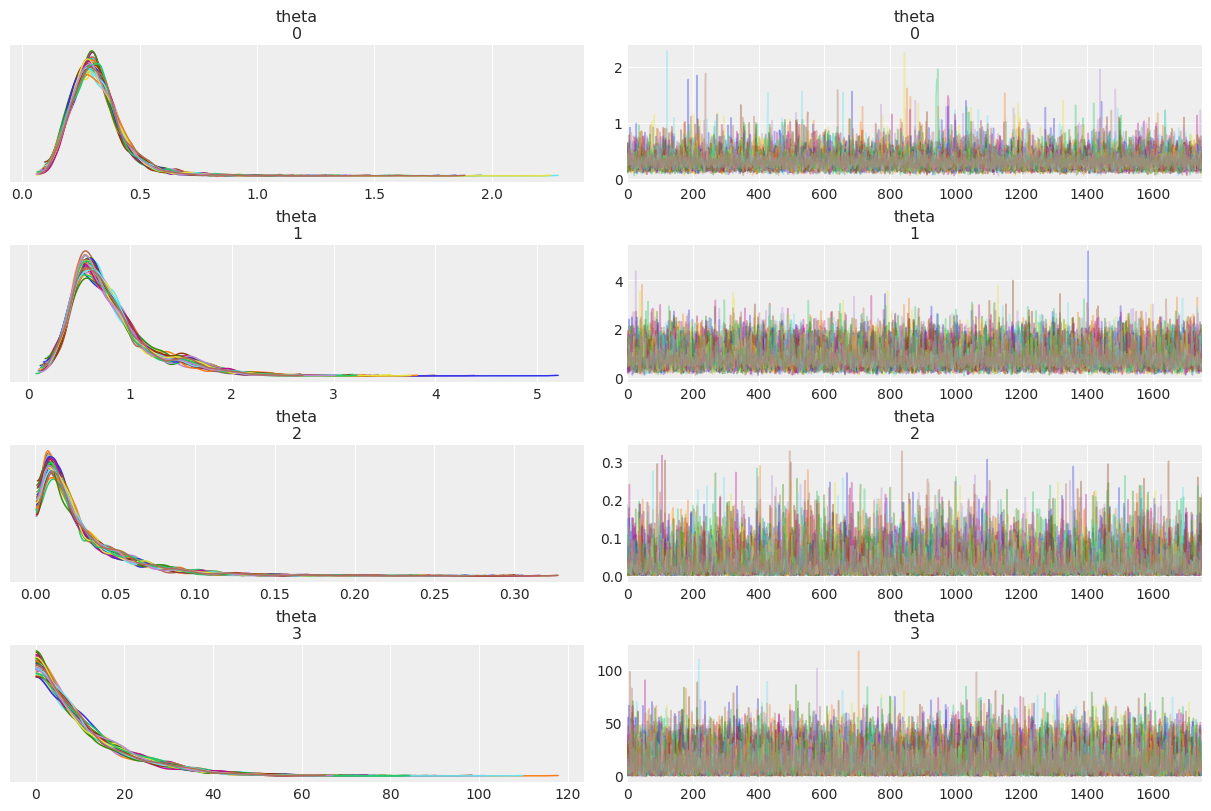

In [416]:
with az.style.context("arviz-darkgrid"):
    az.plot_trace(inference_data, compact=False)

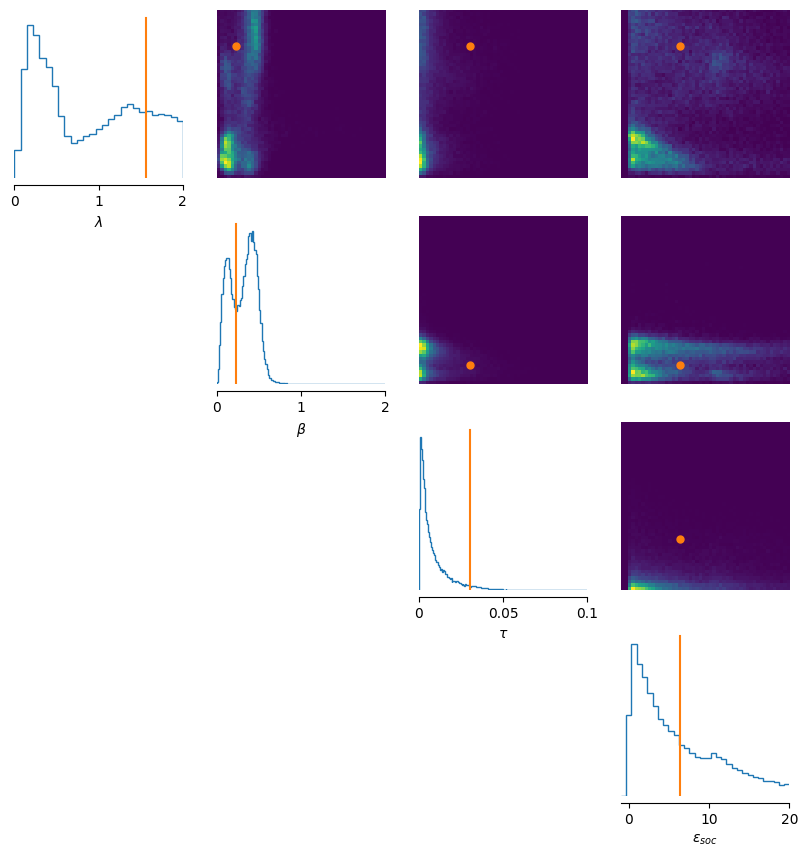

In [502]:
from sbi.analysis import pairplot
params = ["lambda", "beta", "tau", "eps_soc"]  #
labels = ["$\lambda$", "$\\beta$", "$\\tau$", "$\\epsilon_{soc}$"]  #
limits = [[0, 2], [0, 2], [0, 0.1], [-1, 20]]

_ = pairplot(posterior_sample, # .exp(),
             limits=limits,
             points=np.array([fitted_params.loc[params, 'value']]),
             figsize=(10, 10),
             labels=labels,
             )

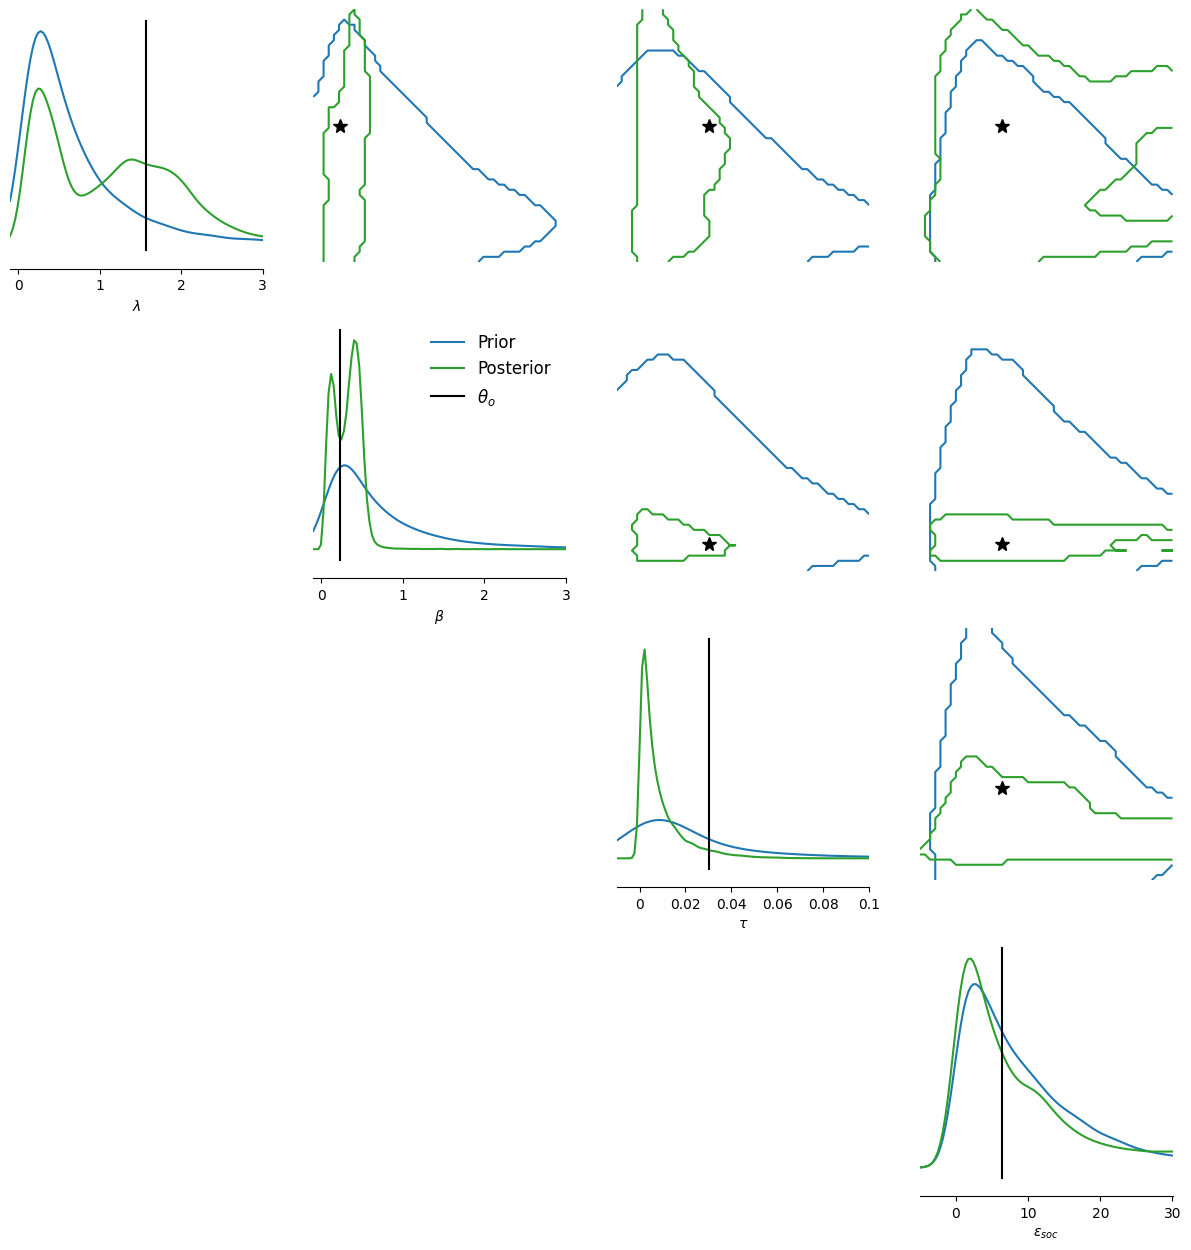

In [503]:
params = ["lambda", "beta", "tau", "eps_soc"]  #
labels = ["$\lambda$", "$\\beta$", "$\\tau$", "$\\epsilon_{soc}$"]  #
limits = [[-0.1, 3], [-0.1, 3], [-0.01, 0.1], [-5, 30]]


fig, ax = pairplot(
    [
        prior.sample((10_000,)), # .exp(),
        posterior_sample, # .exp(),
    ],
    points=np.array([fitted_params.loc[params, 'value']]),
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    limits=limits,
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],
    ),
    labels=labels,
    figsize=(15, 15),
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Posterior", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
)

In [504]:
np.float32(posterior_sample.mean(axis=0))

array([1.1609406e+00, 3.1159103e-01, 8.6829783e-03, 1.1182898e+01],
      dtype=float32)

In [505]:
fitted_params

,value
lambda,1.564209
beta,0.232399
tau,0.030251
eps_soc,6.357610
